# Titanic dataset

Exploring how to set up pipelines for streamlining and automating the machine learning workflow. Combines multiple data preprocessing steps and estimator into a single object. Notebook inspired by https://www.youtube.com/@NeuralNine

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import os

In [57]:
data = pd.read_csv('dataset/train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Exploring the dataset. Name and ticket maybe not relevant. Feature 'SibSp' telles number of siblings/spouses on Titanic. Parch number of parents/children.  

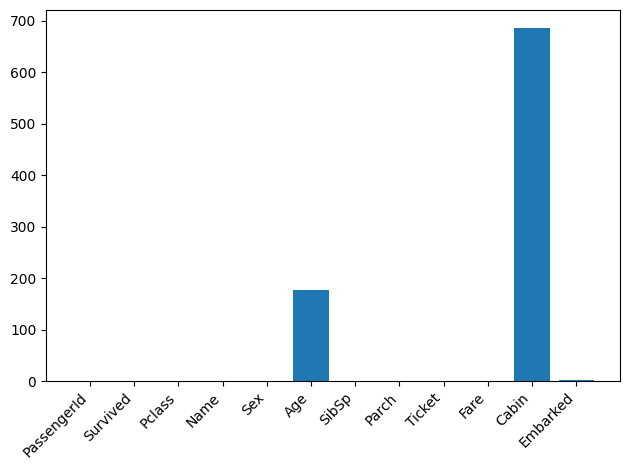

In [58]:
data.shape # (891, 12)

lenX = len(data.columns)
nullList = []
for col in data.columns:
    nullList.append(data[col].isnull().sum()) # sum() counts all the true values in pd.series()

allList = []
for col in data.columns: 
    allList.append(data[col].count())
    
plt.bar(data.columns, nullList)
plt.xticks(rotation=45, ha='right', label="Null values")
plt.tight_layout()
plt.show()

Plot of null values in the dataset. Cabin 

In [59]:
#pd.set_option('display.float_format', lambda x: '%.3f' % x)
data.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Example: 25% is younger than 20.125 y/o while still younger than 75% of the sample population. (25% describe number which is bigger than 25% of the samples, while smaller than 75%) 

<Axes: >

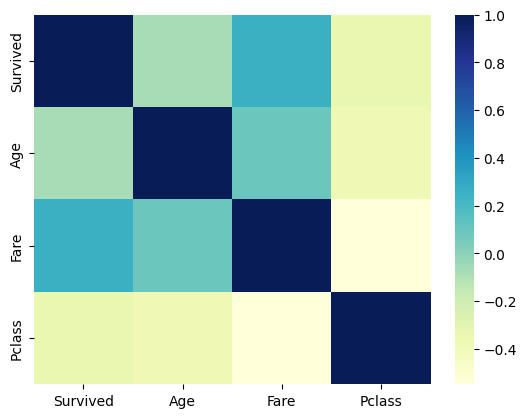

In [60]:
data_cor = data[['Survived','Age', 'Fare', 'Pclass']]


sns.heatmap(data_cor.corr(), cmap="YlGnBu")

Intrested in what's correlated to the survived feature. The fare class is actually higly negatively corr with survivial. Makes sence because survival has class 0 or 1, while Pclass 1,2,3 (1 is the best). (as Pclasses moves from 1 to 3, there is a negative trend in survival..)  

In [61]:
from sklearn.model_selection import StratifiedShuffleSplit

In [62]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2)
split_data = split.split(data, data[["Survived", "Pclass", "Sex"]])

for train_indices, test_indices in split_data:
    strat_train_set = data.loc[train_indices]
    strat_test_set = data.loc[test_indices]


Splitting train and test dataset with StratifiedShuffleSplit. Picks important features and tries having same distribution in both datasets. 

<Axes: >

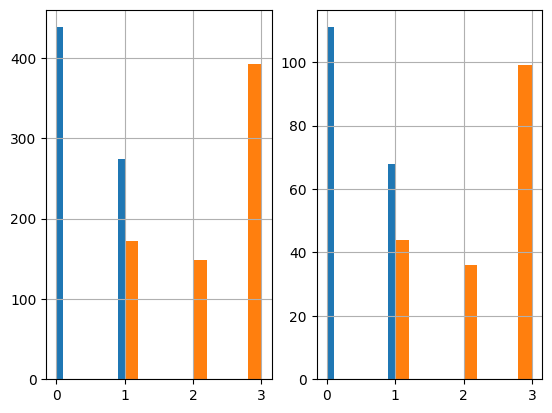

In [63]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()

plt.subplot(1,2,2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()

Distribution follow each other. 

In [64]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 46 to 832
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          576 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        163 non-null    object 
 11  Embarked     711 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


Age data is missing for many of the samples. Could drop or estimators. 

In [65]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer # Strategy for filling in missing values

class AgeImputer(BaseEstimator, TransformerMixin): 
    """ Imputer for Age feature """
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        imputer = SimpleImputer(strategy="mean") # using mean strategy
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X
    

In [66]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [67]:
# testing oneHot

from sklearn.preprocessing import OneHotEncoder
da = ['A', 'B', 'C', 'A', 'C', 'D']
da = np.array(da).reshape(-1, 1)
encoder = OneHotEncoder()
a = encoder.fit_transform(da)
print(a)
print(a.toarray())
print(len(a.toarray()))


  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 0)	1.0
  (4, 2)	1.0
  (5, 3)	1.0
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
6


In [68]:
# from sklearn.preprocessing import OneHotEncoder
# import pandas as pd 

# data = {'price': ['low', 'high', 'medium', 'low', 'low']}
# df = pd.DataFrame(data)
# df


# enocder = OneHotEncoder()
# one_hot_encoded = encoder.fit_transform(df[['price']])
# print(one_hot_encoded.toarray())
# encoder.get_feature_names_out(['price'])

In [69]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin): 
    def fit(self, X, y=None): 
        return self
    
    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Embarked']]).toarray() # creates a one hot encoded matrix

        print(matrix)
        # print(len(matrix))
        column_names = encoder.get_feature_names_out()
        #column_names = ["C", "S", "Q", "N"]
        
        for i in range(len(matrix.T)): 
            X[column_names[i]] = matrix.T[i] # assigns the rows with the one hot encoded rows
        
        matrix = encoder.fit_transform(X[['Sex']]).toarray()  
        column_names = ["Females", "Male"]
                       
        for i in range(len(matrix.T)): 
            X[column_names[i]] = matrix.T[i] # assigns the rows with the one hot encoded rows
        return X

a = FeatureEncoder()
a.transform(data)
    

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,Females,Male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,0.0,1.0,0.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0,0.0,0.0,0.0,1.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.0,0.0,1.0,0.0,1.0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.0,0.0,1.0,0.0,1.0,0.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0.0,0.0,1.0,0.0,0.0,1.0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,0.0,0.0,1.0,0.0,1.0,0.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,0.0,0.0,1.0,0.0,1.0,0.0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1.0,0.0,0.0,0.0,0.0,1.0


In [70]:
class FeatureDropper(BaseEstimator, TransformerMixin): 
    
    def fit(self, X, y=None): 
        return self
    
    def transform(self, X):
        return X.drop(["Embarked", "Name", "Ticket", "Cabin", "Sex", "N"], axis=1, errors="ignore")
    


In [71]:
from sklearn.pipeline import Pipeline 

# Defining the pipeline which the dataset will "flow" thorugh.
pipeline = Pipeline([('ageimputer', AgeImputer()), 
                     ('featureencoder', FeatureEncoder()), 
                     ('featuredropper', FeatureDropper())])


In [72]:
strat_train_set = pipeline.fit_transform(strat_train_set)

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]


Onehot encoded feauters in seperate coloumns

In [73]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 46 to 832
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   712 non-null    int64  
 1   Survived      712 non-null    int64  
 2   Pclass        712 non-null    int64  
 3   Age           712 non-null    float64
 4   SibSp         712 non-null    int64  
 5   Parch         712 non-null    int64  
 6   Fare          712 non-null    float64
 7   Embarked_C    712 non-null    float64
 8   Embarked_Q    712 non-null    float64
 9   Embarked_S    712 non-null    float64
 10  Embarked_nan  712 non-null    float64
 11  Females       712 non-null    float64
 12  Male          712 non-null    float64
dtypes: float64(8), int64(5)
memory usage: 77.9 KB


In [76]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(['Survived'], axis=1)
y = strat_train_set['Survived']
scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()
X_data
# changing the distribution standard deviation to equal one.  

array([[-1.56142706e+00,  8.27893418e-01,  2.68425428e-16, ...,
        -3.75029300e-02, -7.35612358e-01,  7.35612358e-01],
       [ 9.61782107e-01, -3.70196244e-01,  1.67266137e+00, ...,
        -3.75029300e-02, -7.35612358e-01,  7.35612358e-01],
       [-2.00682518e-01,  8.27893418e-01,  8.60055100e-02, ...,
        -3.75029300e-02,  1.35941164e+00, -1.35941164e+00],
       ...,
       [-9.54923780e-01,  8.27893418e-01,  3.12670633e-01, ...,
        -3.75029300e-02, -7.35612358e-01,  7.35612358e-01],
       [ 5.14680328e-01, -3.70196244e-01, -3.67324736e-01, ...,
        -3.75029300e-02,  1.35941164e+00, -1.35941164e+00],
       [ 1.49441640e+00,  8.27893418e-01,  2.68425428e-16, ...,
        -3.75029300e-02, -7.35612358e-01,  7.35612358e-01]])

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 

Ensemble combines multiple models, thus a collection of model is used to make predictions rather than an individual model. Ensemble uses two types of methods, 

- Bagging (Bootstrap Aggregation): Creates different training subset from sample training data with replacement (row sampling with replacement is called bootstrap). Final output based on majority voting (aggregation).  Example Random forrest

- Boosting: Combines multiple simple models (known as weak learners or base estimators) to generate the final output. Builds a model by using weak models in series. Example AdaBoost

Important features of random forest: Not all features are considered while making an individual tree; each tree is different. Immune to the curse of dimensinality, parallelization, stability and no train-test split. 

In [77]:
clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10, 100, 200, 500],
    "max_depth": [None, 5, 10], 
    "min_samples_split": [2,3,4]}
]

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data, y_data)



GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [78]:
final_clf = grid_search.best_estimator_

In [79]:
final_clf

RandomForestClassifier(min_samples_split=4)

In [80]:
strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 681 to 293
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  179 non-null    int64  
 1   Survived     179 non-null    int64  
 2   Pclass       179 non-null    int64  
 3   Name         179 non-null    object 
 4   Sex          179 non-null    object 
 5   Age          138 non-null    float64
 6   SibSp        179 non-null    int64  
 7   Parch        179 non-null    int64  
 8   Ticket       179 non-null    object 
 9   Fare         179 non-null    float64
 10  Cabin        41 non-null     object 
 11  Embarked     178 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 18.2+ KB


In [81]:
X_test = strat_test_set.drop(['Survived'], axis=1)
y_test = strat_test_set['Survived']
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

print(X_data_test.shape)
print(len(y_data_test))

ValueError: could not convert string to float: 'Hassab, Mr. Hammad'

In [235]:
final_clf.score(X_data_test, y_data_test)

0.8324022346368715

In [236]:
final_data = pipeline.fit_transform(data)

X_final = final_data.drop(['Survived'], axis=1)
y_final = final_data['Survived']
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()

891


In [237]:
prod_clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10, 100, 200, 500],
    "max_depth": [None, 5, 10], 
    "min_samples_split": [2,3,4]}
]

grid_search = GridSearchCV(prod_clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data_final, y_data_final)



GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [238]:
final_clf = grid_search.best_estimator_

In [239]:
final_clf

RandomForestClassifier(max_depth=5, n_estimators=500)